In [3]:
import pandas as pd
import numpy as np
import Levenshtein as lev
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
from scipy import spatial

In [547]:
matched_train_data = pd.read_csv("../data/preprocessed/matched_train_data.csv", low_memory=False, lineterminator='\n')
matched_train_data = matched_train_data.dropna(subset=["id_y"]).reset_index()

false_train_data = pd.read_csv("../data/preprocessed/false_train_data.csv", low_memory=False, lineterminator='\n')
false_train_data = false_train_data.dropna(subset=["id_y"]).reset_index()

matched_test_data = pd.read_csv("../data/preprocessed/matched_test_data.csv", low_memory=False, lineterminator='\n')
matched_test_data = matched_test_data.dropna(subset=["id_y"]).reset_index()

false_test_data = pd.read_csv("../data/preprocessed/false_test_data.csv", low_memory=False, lineterminator='\n')
false_test_data = false_test_data.dropna(subset=["id_y"]).reset_index()

random_big_data = pd.read_csv("../data/preprocessed/crossed_all_data.csv", low_memory=False, lineterminator='\n')
random_big_data = random_big_data.dropna(subset=["id_y"]).reset_index()

In [548]:
matched_train_data = matched_train_data.fillna('')
false_train_data = false_train_data.fillna('')
matched_test_data = matched_test_data.fillna('')
false_test_data = false_test_data.fillna('')
random_big_data = random_big_data.fillna('')

In [549]:
matched_train_data_new = pd.read_csv("../data/preprocessed/matched_train_data_new.csv", low_memory=False, lineterminator='\n')
matched_train_data_new = matched_train_data_new.dropna(subset=["id_y"]).reset_index()

false_train_data_new = pd.read_csv("../data/preprocessed/false_train_data_new.csv", low_memory=False, lineterminator='\n')
false_train_data_new = false_train_data_new.dropna(subset=["id_y"]).reset_index()

matched_test_data_new = pd.read_csv("../data/preprocessed/matched_test_data_new.csv", low_memory=False, lineterminator='\n')
matched_test_data_new = matched_test_data_new.dropna(subset=["id_y"]).reset_index()

false_test_data_new = pd.read_csv("../data/preprocessed/false_test_data_new.csv", low_memory=False, lineterminator='\n')
false_test_data_new = false_test_data_new.dropna(subset=["id_y"]).reset_index()

random_big_data_new = pd.read_csv("../data/preprocessed/crossed_all_data_new.csv", low_memory=False, lineterminator='\n')
random_big_data_new = random_big_data_new.dropna(subset=["id_y"]).reset_index()

In [550]:
matched_train_data_new = matched_train_data_new.fillna('')
false_train_data_new = false_train_data_new.fillna('')
matched_test_data_new = matched_test_data_new.fillna('')
false_test_data_new = false_test_data_new.fillna('')
random_big_data_new = crossed_all_data_new.fillna('')

In [8]:
all_big_data = pd.read_csv("../data/preprocessed/all_big_data.csv", low_memory=False, lineterminator='\n')
all_big_data = all_big_data.dropna(subset=["id_y"]).reset_index()

In [9]:
all_big_data = all_big_data.fillna('')

In [10]:
def get_strings_similarity(google_strings, apple_strings, is_devsite=False):
    similarities = []

    for string_index in range(len(google_strings)):
        google_string, apple_string = google_strings[string_index], apple_strings[string_index]
        
        if google_string == "" or apple_string == "":
            similarities.append(0)
            continue

        if is_devsite:
            if google_string in ["google", "blogspot", "facebook", "woqrdpress", "app-ads-txt"] or apple_string in ["google", "blogspot", "facebook", "wordpress", "app-ads-txt"]:
                similarities.append(0)
                continue

        if not isinstance(google_string, str) or not isinstance(apple_string, str):
            similarities.append(0)
            continue
        
        similarities.append(lev.ratio(google_string, apple_string))
    
    return similarities

In [11]:
def get_tfidf_embeddings(documents):
    vectorizer = TfidfVectorizer(lowercase=False)

    return vectorizer.fit_transform(documents)

In [12]:
def get_description_similarity(embeddings):
    similarities = []

    for embeddings_index in range(0, embeddings.shape[0], 2):
        similarities.append(1 - spatial.distance.cosine(embeddings[embeddings_index].toarray().flatten(), embeddings[embeddings_index + 1].toarray().flatten()))
    
    return similarities

In [562]:
def get_matched_dataframe(data):
    title_similarities = get_strings_similarity(data['title_x'], data['title_y'])
    author_similarities = get_strings_similarity(data['author_x'], data['author_y'])
    devsite_similarities = get_strings_similarity(data['devsite_x'], data['devsite_y'], True)

    # combine the description one by one
    x_y_descriptipns = [None]*(len(data['description_x'])+len(data['description_y']))
    x_y_descriptipns[::2] = data['description_x']
    x_y_descriptipns[1::2] = data['description_y']

    embeddings = get_tfidf_embeddings(x_y_descriptipns)

    description_similarities = get_description_similarity(embeddings)
    labels = data['label'] if 'label' in data.columns else [-1] * len(data)

    data = list(zip(title_similarities, author_similarities, devsite_similarities, description_similarities, labels))
    columns = ['title_similarity', 'author_similarity', 'devsite_similarity', 'description_similarity', 'label']

    return pd.DataFrame(data=data, columns=columns)

In [15]:
def concat_df(first, second):
    conc = pd.concat([first, second])
    conc = conc.sample(frac=1)

    return conc.reset_index()

In [491]:
def get_predictions(X, X_t, labels_to_drop):
    model = XGBClassifier()
    model.fit(X.drop(columns=labels_to_drop), X["label"])
    
    y_pred = model.predict(X_t.drop(columns=labels_to_drop))
    y_prob = model.predict_proba(X_t.drop(columns=labels_to_drop))

    return y_pred, y_prob

# Soft train test

In [192]:
false_train_data_labeld = false_train_data.copy()
false_train_data_labeld['label'] = 0

matched_train_data_labeld = matched_train_data.copy()
matched_train_data_labeld['label'] = 1

In [196]:
X_train_data = concat_df(false_train_data_labeld, matched_train_data_labeld)

In [198]:
X_train = get_matched_dataframe(X_train_data)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [213]:
false_matched_test_data_labeld = false_test_data.copy()
false_matched_test_data_labeld['label'] = 0

matched_test_data_labeld = matched_test_data.copy()
matched_test_data_labeld['label'] = 1

In [214]:
X_test_data = concat_df(false_matched_test_data_labeld, matched_test_data_labeld)
X_test = get_matched_dataframe(X_test_data)

In [492]:
soft_pred, soft_prob = get_predictions(X_train, X_test, ["label"])
soft_score = balanced_accuracy_score(X_test['label'], soft_pred)
soft_score

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9987725792701363

## Hard train test

In [22]:
def get_hard_data(data):
    data_sum = data.copy()
    data_sum['sum'] = data_sum.drop(columns=["label"]).sum(axis=1)
    data_sum_top_25 = data_sum.nlargest(int(data.shape[0] * 0.25), 'sum')
    print(data_sum_top_25["sum"].mean(), data.drop(columns=["label"]).sum(axis=1).mean())
    return data_sum_top_25

In [216]:
X_train_hard = get_hard_data(X_train)
X_test_hard = get_hard_data(X_test)

2.6625209725715244 1.0969351461092005
2.7999090967257194 1.1380174214277945


In [217]:
hard_pred = get_predictions(X_train_hard, X_test_hard, ["label", "sum"])
average_precision = balanced_accuracy_score(X_test_hard["label"], hard_pred)
average_precision

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.9974415393388116

## confusion matrix

In [283]:
soft_pred_1_index = np.where(soft_pred == 1)[0]
X_test_1 = X_test.iloc[soft_pred_1_index]
X_test_1_data = X_test_data.iloc[X_test_1.index]

[[76799    21]
 [   37 16924]]


<AxesSubplot:>

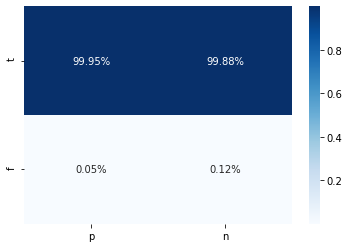

In [385]:
cm = confusion_matrix(X_test['label'], soft_pred)
cm_plot = np.array([[cm[0][0], cm[1][1]], [cm[1][0], cm[0][1]]])
sn.heatmap(cm_plot/np.sum(cm_plot, axis=0), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=['p', 'n'], yticklabels=['t', 'f'])

# Old VS New

<h3>
diff: <br>
partition in title and author
<br>
no black list in devsite
</h3>

In [28]:
%%time 

false_train_data_matched = get_matched_dataframe(false_train_data, label=0)
train_data_matched = get_matched_dataframe(matched_train_data, label=1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


CPU times: user 17min 5s, sys: 8.52 s, total: 17min 13s
Wall time: 17min 15s


In [29]:
X_train = concat_df(false_train_data_matched, train_data_matched)

In [30]:
%%time 

false_test_data_matched = get_matched_dataframe(false_test_data, label=0)
test_data_matched = get_matched_dataframe(matched_test_data, label=1)

CPU times: user 1min 24s, sys: 872 ms, total: 1min 24s
Wall time: 1min 25s


In [31]:
X_test = concat_df(false_test_data_matched, test_data_matched)

In [32]:
%%time 

false_train_data_matched_new = get_matched_dataframe(false_train_data_new, label=0)
train_data_matched_new = get_matched_dataframe(matched_train_data_new, label=1)

CPU times: user 11min 19s, sys: 1min 48s, total: 13min 7s
Wall time: 13min 9s


In [33]:
X_train_new = concat_df(false_train_data_matched_new, train_data_matched_new)

In [34]:
%%time 

false_test_data_matched_new = get_matched_dataframe(false_test_data_new, label=0)
train_test_matched_new = get_matched_dataframe(matched_test_data_new, label=1)

CPU times: user 50.1 s, sys: 620 ms, total: 50.7 s
Wall time: 50.9 s


In [35]:
X_test_new = concat_df(false_test_data_matched_new, train_test_matched_new)

In [36]:
model = XGBClassifier()
model.fit(X_train.drop(columns=["label"]), X_train["label"])
    
y_pred = model.predict(X_test.drop(columns=["label"]))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [37]:
score_old = balanced_accuracy_score(X_test["label"], y_pred)
score_old

0.9987235737111715

In [38]:
model_new = XGBClassifier()
model_new.fit(X_train_new.drop(columns=["label"]), X_train_new["label"])

y_pred_new = model_new.predict(X_test_new.drop(columns=["label"]))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [39]:
score_new = balanced_accuracy_score(X_test_new["label"], y_pred_new)
score_new

0.9991716481685138

# Big Data

<h3> Big data with same titles <br>
1:5 of matched and unmatched ratio

In [40]:
%%time 

all_big_data_matched = get_matched_dataframe(all_big_data, label=0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


CPU times: user 41min, sys: 3min 37s, total: 44min 38s
Wall time: 44min 47s


In [598]:
all_big_data_matched.head(10)

,title_similarity,author_similarity,devsite_similarity,description_similarity,label
0,0.307692,0.357143,0.000000,0.060270,0
1,1.000000,1.000000,1.000000,0.972792,0
2,0.000000,0.272727,0.285714,0.004546,0
3,0.129032,0.230769,0.117647,0.069634,0
4,0.000000,0.272727,0.000000,0.000000,0
5,0.313725,0.255319,0.000000,0.008111,0
6,1.000000,1.000000,1.000000,1.000000,0
7,1.000000,1.000000,0.000000,0.087237,0
8,0.333333,0.320000,0.000000,0.034762,0
9,0.210526,0.000000,0.000000,0.025338,0


In [512]:
y_pred_big = model_new.predict(all_big_data_matched.drop(columns=["label"]))
y_prob_big = model_new.predict_proba(all_big_data_matched.drop(columns=["label"]))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [530]:
similar_couples_indexes = np.where(y_pred_big == 1)[0]
similar_couples = all_big_data_matched.loc[similar_couples_indexes]
similar_couples_data = all_big_data.loc[similar_couples_indexes]
y_proba_similar_couples = y_prob_big[similar_couples_indexes]

In [534]:
similar_couples_data['proba_0'] = y_proba_similar_couples[:, 0]
similar_couples_data['proba_1'] = y_proba_similar_couples[:, 1]

In [541]:
similar_couples_data.sort_values(['proba_1'],ascending=False).groupby('id_x').head(3)

,index,id_x,store_x,apple_maincategory_x,google_maincategory_x,title_x,author_x,devsite_x,description_x,id_y,store_y,apple_maincategory_y,google_maincategory_y,title_y,author_y,devsite_y,description_y,proba_0,proba_1
257787,257787,com.inmystream.verahitradio,0,,Music,vera hit radio,inmystream,verahitradio,la radio delle hits che hanno fatto e faranno ...,1450361738,1,6016,,vera hit radio,andrea giordano,verahitradio,la radio delle hits che hanno fatto e faranno ...,3.576279e-07,1.000000
255562,255562,es.alberiteparticipa,0,,COMMUNICATION,alberite participa,fructusoft,fructusoft,descargando esta aplicacion gratuita estara en...,1500040657,1,6002,,alberite participa,octavio ruiz espinosa,fructusoft,descargando esta aplicacion gratuita estara en...,3.576279e-07,1.000000
119600,119600,com.jerryghionis.app,0,,Photo Video,jerry ghionis,live portrait,jerryghionis,whether you want to learn photography from jer...,1347708295,1,6008,,jerry ghionis,interactive images,ghionis,whether you want to learn photography from jer...,3.576279e-07,1.000000
254936,254936,mobi.easyorderapp.petruzzi,0,,Shopping,petruzzi,easyorder,easyorderapp,ou que vous soyez avec lapplication petruzzi v...,1516182527,1,6024,,petruzzi,nicolas petruzzi,easyorderapp,ou que vous soyez avec lapplication de quick p...,3.576279e-07,1.000000
320324,320324,com.oneminorder.panirpecs,0,,Food and Drink,panír pécs,innovair marketing and oneminorder,oneminorder,rendelj gyorsan es egyszeruen a pecsi panir pe...,1503336731,1,6023,,panír pécs,attila antal gur,oneminorder,rendelj gyorsan es egyszeruen a pecsi panir pe...,3.576279e-07,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374324,374324,com.subsplash.thechurchapp.s_D2XKGD,0,,Education,mycbc - easley sc,subsplash,subsplash,mycbc is created for the local community and c...,1455397027,1,6017,,victory church il,victory christian ministries,subsplash,victory church exists to see people saved heal...,4.903960e-01,0.509604
133598,133598,com.qcsaq200.afllv833,0,,Health and Fitness,egg recipes,nadiadev,,egg recipesin this app you can see this topic ...,1390362383,1,6023,,hindi recipes,vinod m,bomosi,recipes in hindi language hindi recipes app is...,4.905835e-01,0.509416
524940,524940,com.uneedappsenglish.to.english.dictionary,0,,Education,english dictionary,uneedapps,,english dictionary provides the access to the ...,1495124402,1,6000,,management dictionary,donik ariyanto,blogspot,this application provides a variety of vocabul...,4.933746e-01,0.506625
246107,246107,tw.net.sun.ctms.cpdc,0,,Games,1314樂學網,sun net technologies,sun,le xue wang ti gong xue xi zhe ke sui shi sui...,1033044640,1,6017,,友心情,tung wah group of hospitals,radioicare,dong hua san yuan radioicareyou xin qing wang ...,4.963650e-01,0.503635


## Checking for module result unmatched apps with similar title

In [514]:
all_big_data_matched_title_1_index = all_big_data_matched[all_big_data_matched['title_similarity'] == 1].index
y_pred_big_1_index = np.where(y_pred_big == 1)[0]
missed_titles_indexes = np.array([x for x in all_big_data_matched_title_1_index if x not in y_pred_big_1_index])

In [515]:
mised_titles_data = all_big_data.iloc[missed_titles_indexes]
mised_titles_similarties = all_big_data_matched.iloc[missed_titles_indexes]


In [516]:
matched_title_pred_1 = all_big_data_matched.loc[np.where(y_pred_big == 1)[0]]

Text(0.5, 1.0, 'Author')

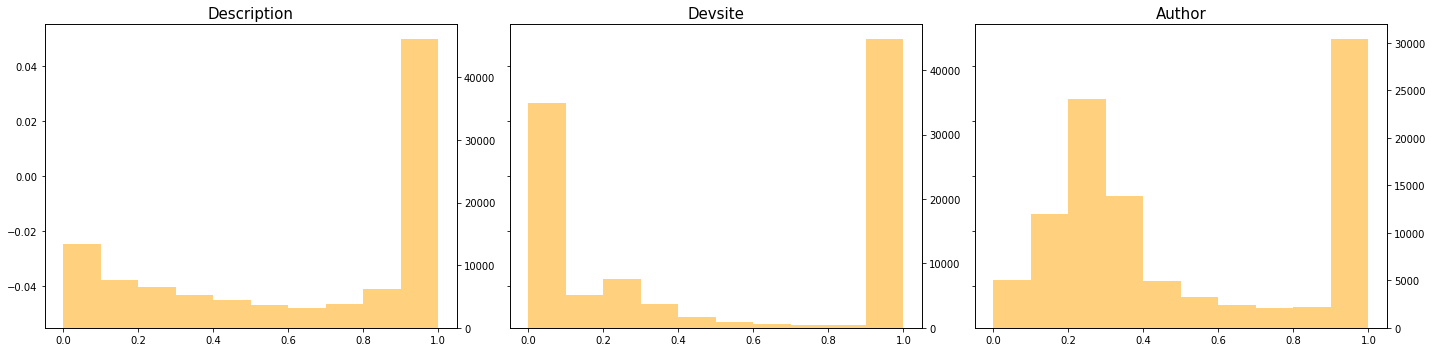

In [517]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True, tight_layout=True)
n_bins = 10
alpha = 0.5

axs[0].hist(mised_titles_similarties['description_similarity'], bins=n_bins)
ax0_twix = axs[0].twinx()
ax0_twix.hist(matched_title_pred_1['description_similarity'], alpha=0.5, color='orange', bins=n_bins)
axs[0].set_title('Description', fontsize=15)

axs[1].hist(mised_titles_similarties['devsite_similarity'], bins=n_bins)
ax1_twix = axs[1].twinx()
ax1_twix.hist(matched_title_pred_1['devsite_similarity'], alpha=0.5, color='orange', bins=n_bins)
axs[1].set_title('Devsite', fontsize=15)

axs[2].hist(mised_titles_similarties['author_similarity'], bins=n_bins)
ax2_twix = axs[2].twinx()
ax2_twix.hist(matched_title_pred_1['author_similarity'], alpha=0.5, color='orange', bins=n_bins)
axs[2].set_title('Author', fontsize=15)

# Random big data

In [563]:
%%time 

random_big_data_new_matched = get_matched_dataframe(random_big_data_new)

CPU times: user 8min 31s, sys: 13.5 s, total: 8min 44s
Wall time: 8min 48s


In [566]:
y_pred_random_big_data_new = model_new.predict(random_big_data_new_matched.drop(columns=["label"]))
y_prob_random_big_data_new = model_new.predict_proba(random_big_data_new_matched.drop(columns=["label"]))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [568]:
# random_big_data_similar_couples_indexes = np.where(y_pred_random_big_data_new == 1)[0]

# random_big_data_similar_couples = random_big_data_new_matched.loc[random_big_data_similar_couples_indexes]
# random_big_data_similar_couples_data = random_big_data_new.loc[random_big_data_similar_couples_indexes]
# random_big_data_y_proba_similar_couples = y_prob_random_big_data_new[random_big_data_similar_couples_indexes]

In [576]:
random_big_data_copy = random_big_data.copy()
random_big_data_copy['proba_0'] = y_prob_random_big_data_new[:, 0]
random_big_data_copy['proba_1'] = y_prob_random_big_data_new[:, 1]

In [579]:
random_big_data_copy[random_big_data_copy["id_x"] == "com.ctconnect.betshean"]	

,index,id_x,store_x,apple_maincategory_x,google_maincategory_x,title_x,author_x,devsite_x,description_x,id_y,store_y,apple_maincategory_y,google_maincategory_y,title_y,author_y,devsite_y,description_y,proba_0,proba_1
606000,606000,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,980196807,1,6007,,timelime,niko,timelimeapp,with timelime for iphone you can easily track ...,0.999990,0.000010
606001,606001,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,980196880,1,6000,,los,busca-ayuda.com,loslupes,los lupes started to operate in on the corner...,0.999947,0.000053
606002,606002,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,980196905,1,6016,,芸人検定,yoshihiro,sweetdoctor,nannotsu \npisutachionoshi jie hegozhao dai it...,0.999985,0.000015
606003,606003,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,980196941,1,6004,,ゴルフの法則クイズ,kiyoyuki,fc2,anataha goruhunofa ze wodonokuraizhi tsutemasu...,0.999859,0.000141
606004,606004,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,980196971,1,6002,,trafikensuche,monopolverwaltung,mvg,holen sie sich jetzt die offizielle trafikensu...,0.999939,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606995,606995,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,1112034516,1,6016,,攻略ニュースまとめ,hiroya,bit,shi kuang pawahurupuroye qiu pawapurosakusesus...,0.999873,0.000127
606996,606996,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,1112035031,1,6002,,bnetfax,hangzhou,hzdracom,shi yao shi zhong guo dian xin shou ji chuan z...,0.997679,0.002321
606997,606997,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,1112035423,1,6003,,muji,qup,qupworld,its now easy and hassle free to take a ride b...,0.999997,0.000003
606998,606998,com.ctconnect.betshean,0,,TOOLS,בית,ctconnect,ctconnect,haplyqtsyh hrshmyt shl yryyt byt shan\n\nhshyr...,1112035428,1,6003,,muji,qup,qupworld,muji driver is an ideal moneyearning tool for ...,0.999997,0.000003


In [597]:
xxx = random_big_data_copy.sort_values(['id_x', 'proba_1'],ascending=False).groupby('id_x').head(3)
xxx[["id_x", "id_y", "proba_1"]].head(20)

,id_x,id_y,proba_1
590803,zw.co.cowork.club.androidoverview,1111925704,0.999872
590987,zw.co.cowork.club.androidoverview,1112029170,0.006156
590681,zw.co.cowork.club.androidoverview,1111842975,0.004962
38454,zero.qcash.syria,980533710,0.005662
38555,zero.qcash.syria,980583194,0.005662
38725,zero.qcash.syria,1111873503,0.005662
447003,zentres.bieshof,980196941,0.003007
447451,zentres.bieshof,980532310,0.003007
447633,zentres.bieshof,1111831185,0.002369
134907,za.co.glowlight.sweeread1,1111955273,0.020461


## Exploring the positive values proba distribution

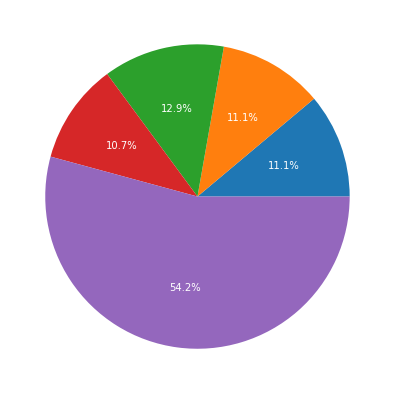

In [484]:
pos_preds = np.where(y_pred_crossed_new == 1)[0]
pos_scores = y_pred_crossed_new_prob[pos_preds]
pos_scores_1 = pos_scores[:, 1]
ranges = [0.5, 0.6, 0.7, 0.8, 0.9, 1.01] # should be even
sum_in_ranges = []

for rnge_index in range(len(ranges) - 1):
    range_sum = ((pos_scores_1 >= ranges[rnge_index]) & (pos_scores_1 < ranges[rnge_index+1])).sum()
    sum_in_ranges.append(range_sum)

fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.pie(sum_in_ranges, autopct='%1.1f%%', labels=['0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.1'],  textprops={'color':"w"})

plt.show()

In [409]:
# # 113
# from IPython.display import display, HTML

# i = 0

# for index in np.where(y_pred_crossed_new == 1)[0]:
#     score = crossed_all_data_matched_new[crossed_all_data_matched_new.index == index]
#     score_copy = score.copy()
    
#     score_copy["prob_0"] = y_pred_corssed_new_prob[index][0]
#     score_copy["prob_1"] = y_pred_corssed_new_prob[index][1]

#     # if score_copy["prob_0"].values[0] > score_copy["prob_1"].values[0]:
#     i += 1
#     print(i)
#     row = crossed_all_data_new[crossed_all_data_new.index == index]
    
#     display(HTML(score_copy.to_html()))
#     display(HTML(row[crossed_all_data_new.columns.drop(['description_x', 'description_y'])].to_html()))
#         # display(HTML(row[['description_x', 'description_y']].to_html()))
#         # print('\n\n\n')

# PCA

In [54]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

pca = PCA()
X = all_big_data_matched.drop(columns=["label"]).fillna(0)
X_train_transform = X_train.drop(columns=["label"]).fillna(0)

X_transformed = pca.fit_transform(X)
X_train_transformed = pca.transform(X_train_transform)
eigenvalues = pca.explained_variance_

print(eigenvalues)

[0.20345207 0.04144098 0.02349783 0.01597374]


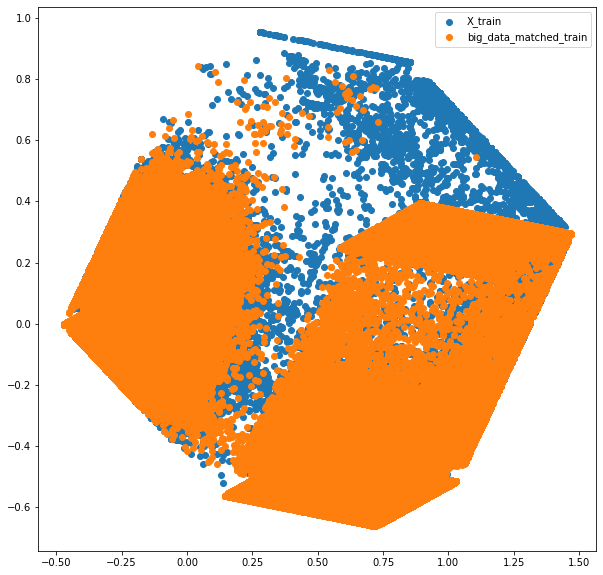

In [387]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(10, 10))
plt.scatter(X_train_transformed[:,0],X_train_transformed[:,1], label="X_train")
plt.scatter(X_transformed[:,0],X_transformed[:,1], label="big_data_matched_train")

plt.legend()
plt.show()